# Alzheimer's Disease and Healthy Aging

In [1]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier


import seaborn as sns
from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

from lazypredict.Supervised import LazyClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

In [2]:
# Import data
df = pd.read_csv("alzheimers_disease_data.csv")
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.93,0,13.30,6.33,1.35,...,0,0,1.73,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.83,0,4.54,7.62,0.52,...,0,0,2.59,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.80,0,19.56,7.84,1.83,...,0,0,7.12,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.80,1,12.21,8.43,7.44,...,0,1,6.48,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.72,0,18.45,6.31,0.80,...,0,0,0.01,0,0,1,1,0,0,XXXConfid


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

Since the relevant categorical variables (gender, ethnicity, education level etc.) are already encoded as integers, we will not have to perform One Hot Encoding on these columns.

In [ ]:
# Checking for null values
df.isna().sum()

# Data Cleaning

### Dropped columns
* __PatientID__ (Doesn't tell us anything useful)
* __DoctorInCharge__ (Confidential and doesn't tell us anything useful)

### Null Values
* There are luckily no null values so we will not have to perform any imputing

### Handling Categorical and Numerical Features
* 

In [3]:
df.drop(columns=['PatientID', 'DoctorInCharge'], inplace=True)

df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.93,0,13.30,6.33,1.35,9.03,...,6.52,0,0,1.73,0,0,0,1,0,0
1,89,0,0,0,26.83,0,4.54,7.62,0.52,7.15,...,7.12,0,0,2.59,0,0,0,0,1,0
2,73,0,3,1,17.80,0,19.56,7.84,1.83,9.67,...,5.90,0,0,7.12,0,1,0,1,0,0
3,74,1,0,1,33.80,1,12.21,8.43,7.44,8.39,...,8.97,0,1,6.48,0,0,0,0,0,0
4,89,0,0,0,20.72,0,18.45,6.31,0.80,5.60,...,6.05,0,0,0.01,0,0,1,1,0,0


In [155]:
# Checking for duplicates
df.duplicated().sum()

0

In [4]:
# To make it easier, I changed 'Diagnosis' to 'target'
df.rename(columns={'Diagnosis': 'target'}, inplace=True)

df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,target
0,73,0,0,2,22.93,0,13.30,6.33,1.35,9.03,...,6.52,0,0,1.73,0,0,0,1,0,0
1,89,0,0,0,26.83,0,4.54,7.62,0.52,7.15,...,7.12,0,0,2.59,0,0,0,0,1,0
2,73,0,3,1,17.80,0,19.56,7.84,1.83,9.67,...,5.90,0,0,7.12,0,1,0,1,0,0
3,74,1,0,1,33.80,1,12.21,8.43,7.44,8.39,...,8.97,0,1,6.48,0,0,0,0,0,0
4,89,0,0,0,20.72,0,18.45,6.31,0.80,5.60,...,6.05,0,0,0.01,0,0,1,1,0,0


# Feature Engineering

1. Health Score
    - This metric is a combination of health measures into one score, from 0 to 1, with 1 representing perfect health and 0 representing bad health.
    - The weights assigned were calculated using Feature Importance from a random forest model, which shows the specific weights assigned to each attribute that is related to health. This is done to ensure each attribute is being accurately assessed on its contributions to overall health score
2. Count of Health Issues
    - Combining __FamilyHistoryAlzheimers__, __CardiovascularDisease__, __Diabetes__, __Depression__, __HeadInjury__, __Hypertension__ into a count of health issues according to medical history
3. Education + Ethnicity
    - Highlights the interaction between the two variables.
        - 0_0 represents a Caucasian with no education
        - 0_1 represents a Caucasian with a high school diploma
        - 0_2 represents a Caucasian with a bachelor's degree
        - 0_3 represents a Caucasian with an advanced degree
        - The same applies for 1_X (African American), 2_X (Asian), or 3_X (Other)

In [5]:
# Define helper function to get weights of the columns
def get_weights(df, columns):
    X = df[columns]
    y = df['target']
    model = RandomForestClassifier()
    model.fit(X, y)
    weights = model.feature_importances_
    return dict(zip(columns, weights))


# Define column names and get weights
health_columns = ['BMI', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'Smoking', 'AlcoholConsumption']
health_weights = get_weights(df, health_columns)

cardiometabolic_columns = ['SystolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
                           'CholesterolTriglycerides']
cardiometabolic_weights = get_weights(df, cardiometabolic_columns)

# # Update DF
# scaler = MinMaxScaler()
# 
# # Update health related columns
# for col in health_columns:
#     df[col] = scaler.fit_transform(df[[col]])
# 
# # Update cardiometabolic related columns
# for col in cardiometabolic_columns:
#     df[col] = scaler.fit_transform(df[[col]])

# Calculate HealthScore, CardiometabolicIndex and TotalHealthScore
df['HealthScore'] = sum(df[col] * weight for col, weight in health_weights.items())
df['CardiometabolicIndex'] = sum(df[col] * weight for col, weight in cardiometabolic_weights.items())
df['TotalHealthScore'] = df['HealthScore'] + df['CardiometabolicIndex']

# # Normalize CardiometabolicIndex and TotalHealthScore
# for col in ['CardiometabolicIndex', 'TotalHealthScore']:
#     df[col] = scaler.fit_transform(df[[col]])

df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,target,HealthScore,CardiometabolicIndex,TotalHealthScore
0,73,0,0,2,22.93,0,13.30,6.33,1.35,9.03,...,1.73,0,0,0,1,0,0,10.30,125.88,136.19
1,89,0,0,0,26.83,0,4.54,7.62,0.52,7.15,...,2.59,0,0,0,0,1,0,9.11,184.43,193.53
2,73,0,3,1,17.80,0,19.56,7.84,1.83,9.67,...,7.12,0,1,0,1,0,0,11.01,138.91,149.92
3,74,1,0,1,33.80,1,12.21,8.43,7.44,8.39,...,6.48,0,0,0,0,0,0,13.74,137.97,151.71
4,89,0,0,0,20.72,0,18.45,6.31,0.80,5.60,...,0.01,0,0,1,1,0,0,10.05,156.03,166.08


In [ ]:
print(health_weights, '\n', cardiometabolic_weights)

In [6]:
# Creating count of health issues
health_issues_columns = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension']
df['NumHealthIssues'] = df[health_issues_columns].sum(axis=1)

In [7]:
# Creating Education + Ethnicity
df['EducationEthnicity'] = df['Ethnicity'].astype(str) + "_" + df['EducationLevel'].astype(str)

# Exploratory Data Analysis

In [ ]:
df.describe().T

Takeaways:
- The people in this dataset, on average, are less educated (1.2)
- There are more smokers in this dataset (0.71)
- Physical activity, diet quality, and sleep quality are generally average, at around 0.5
- Most of the data points in this dataset have no Alzheimer's diagnosis (around 65%)

#### Looking at balance of the target variable

In [ ]:
# Plotting histogram of 'target'
df['target'].hist(bins=2, figsize=(5,5))

# Getting count of diagnoses of NO and YES
print(f"Not Diagnosed with Alzheimer's Count: {(df['target'] == 0).sum()} ({round((df['target'] == 0).sum() / df.shape[0] * 100, 2)}%)")
print(f"Diagnosed with Alzheimer's Count: {(df['target'] == 1).sum()} ({round((df['target'] == 1).sum() / df.shape[0] * 100, 2)}%)")
plt.show()

Interpretation: 64% of patients in this dataset were not diagnosed, while 35% were diagnosed. This represents a moderately unbalanced dataset, which might be addressed later

In [ ]:
df.hist(figsize=(20,20))
plt.show()

Let's take a look at correlations now

In [ ]:
# Creating correlation matrix
correlations = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='RdBu')
plt.show()

In [ ]:
# looking at correlation with target more closely
correlations['target'].sort_values(ascending=False)

### Interpretation:
- **MemoryComplaints** is the most highly correlated feature. It makes sense, as Alzheimer's is associated with a decline in memory, so the more memory complaints, the more likely it is that patient develops Alzheimer's
- **BehavioralProblems** is the second most highly correlated feature, which also makes sense as more behavioral problems are associated with Alzheimer's
- Interestingly enough, metrics like **TotalHealthScore**, any health metric like **PhysicalActivity**, and **Smoking** or **AlcoholConsumption** do not seem to be correlated. This might be due to the interaction these columns have with **CardiovascularDisease**, which seems to be more correlated, albeit not by much.

# Data Processing

* For this processing, I decided to use MinMaxScalar over StandardScalar because the data is generally not normally distributed and we are dealing with variables such as age etc.

In [8]:
# Defining target
y = df['target']

# Define features
X = df.drop(columns='target')

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [9]:
# Building preprocessor

# Separating into nominal, ordinal, and continuous columns
nominal_cols = ['Gender', 'Ethnicity', 'Smoking', 'FamilyHistoryAlzheimers',
                'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury',
                'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
                'Confusion', 'Disorientation', 'PersonalityChanges',
                'DifficultyCompletingTasks', 'Forgetfulness']

ordinal_cols = ['EducationLevel']

continuous_cols = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
                   'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
                   'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
                   'MMSE', 'FunctionalAssessment', 'ADL', 'HealthScore',
                   'CardiometabolicIndex', 'TotalHealthScore']

# Complete pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), continuous_cols + ordinal_cols),
        ('cat', 'passthrough', nominal_cols)])

train = preprocessor.fit_transform(X_train)
test = preprocessor.transform(X_test)

# Getting feature names
feature_names = preprocessor.get_feature_names_out(list(X.columns))

# Model Building

Now it's time to test out some models!

In [20]:
# Lazy Classifier is great to use for a baseline of the best performing models, without
# any hyperparameter tuning
# This will be used to assess the models further
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display the results
print(models)

100%|██████████| 29/29 [00:02<00:00, 10.60it/s]

[LightGBM] [Info] Number of positive: 607, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4087
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353112 -> initscore=-0.605387
[LightGBM] [Info] Start training from score -0.605387
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.96               0.95     0.95      0.96   
XGBClassifier                      0.95               0.94     0.94      0.95   
BaggingClassifier                  0.94               0.93     0.93      0.94   
RandomForestClassifier             0.93  

In [11]:
# Starting out with KNN
# Hyperparameter optimization for KNN model
# Define the parameter grid
params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'leaf_size': [10, 20, 30, 40, 50, 60],
    'p': [1, 2, 3]
}


# Instantiate the grid search model
grid_search_knn = HalvingGridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_knn.fit(train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search_knn.best_params_)
print("Best Score: ", grid_search_knn.best_score_)



Best Parameters:  {'algorithm': 'auto', 'leaf_size': 40, 'metric': 'manhattan', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
Best Score:  0.7302872966424369


Test Accuracy (KNN): 72.093
              precision    recall  f1-score   support

           0       0.72      0.94      0.81       277
           1       0.75      0.32      0.45       153

    accuracy                           0.72       430
   macro avg       0.73      0.63      0.63       430
weighted avg       0.73      0.72      0.68       430

AUC-ROC score for KNN is 0.8036620183572827


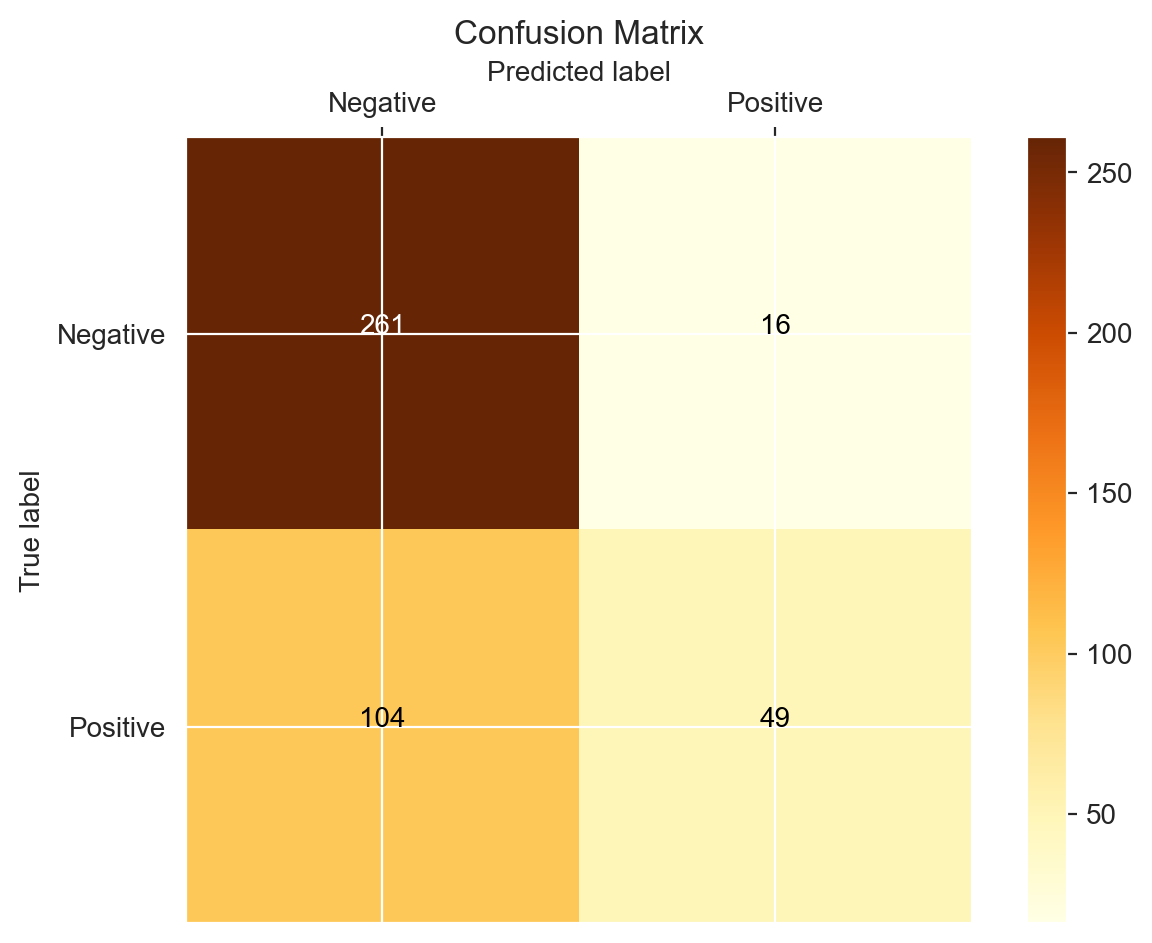

In [12]:
# Using fitted model to make predictions
best_knn_model = grid_search_knn.best_estimator_
test_predictions_knn = best_knn_model.predict(test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, test_predictions_knn)

# Print the test accuracy
print(f"Test Accuracy (KNN): {test_accuracy*100:.3f}")

# Classification Report
print(metrics.classification_report(y_test, test_predictions_knn))

# Predict probabilities
probabilities_knn = best_knn_model.predict_proba(test)

# Probabilities for positive class
auc = roc_auc_score(y_test, probabilities_knn[:, 1])

print(f"AUC-ROC score for KNN is {auc}")

# Confusion Matrix
draw_confusion_matrix(y_test, test_predictions_knn, ['Negative', 'Positive'])

In [13]:
# Logistic regression

# Instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=1000)

params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False]
}


# Instantiate the grid search model
grid_search_log = HalvingGridSearchCV(estimator=logreg, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_log.fit(train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search_log.best_params_)
print("Best Score: ", grid_search_log.best_score_)

/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/aidan

Best Parameters:  {'C': 10, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  0.8452232606438214


/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75833333        nan 0.75833333 0.75833333
 0.75833333 0.75833333 0.75833333 0.75833333        nan        nan
        nan        nan        nan 0.64166667 0.64166667        nan
 0.64166667 0.66666667        nan        nan 0.75833333        nan
 0.75833333 0.75833333 0.75833333 0.75833333 0.75833333 0.75833333
        nan        nan        nan        nan        nan 0.64166667
 0.61666667        nan 0.66666667 0.66666667        nan        nan
 0.75833333        nan 0.65833333 0.75833333 0.75833333 0.75833333
 0.75833333 0.75833333        nan        nan        nan        nan
        nan 0.64166667 0.64166667        nan 0.61666667 0.64166667
        nan        nan 0.75833333        nan 0.75833333 0.75833333
 0.75833333 0.75833333 0.75833333 0.75833333        nan        nan
        nan

Test Accuracy (Logistic Regression): 82.791
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       277
           1       0.78      0.71      0.75       153

    accuracy                           0.83       430
   macro avg       0.82      0.80      0.81       430
weighted avg       0.83      0.83      0.83       430

AUC-ROC score for Logistic Regression is 0.8941978716877845


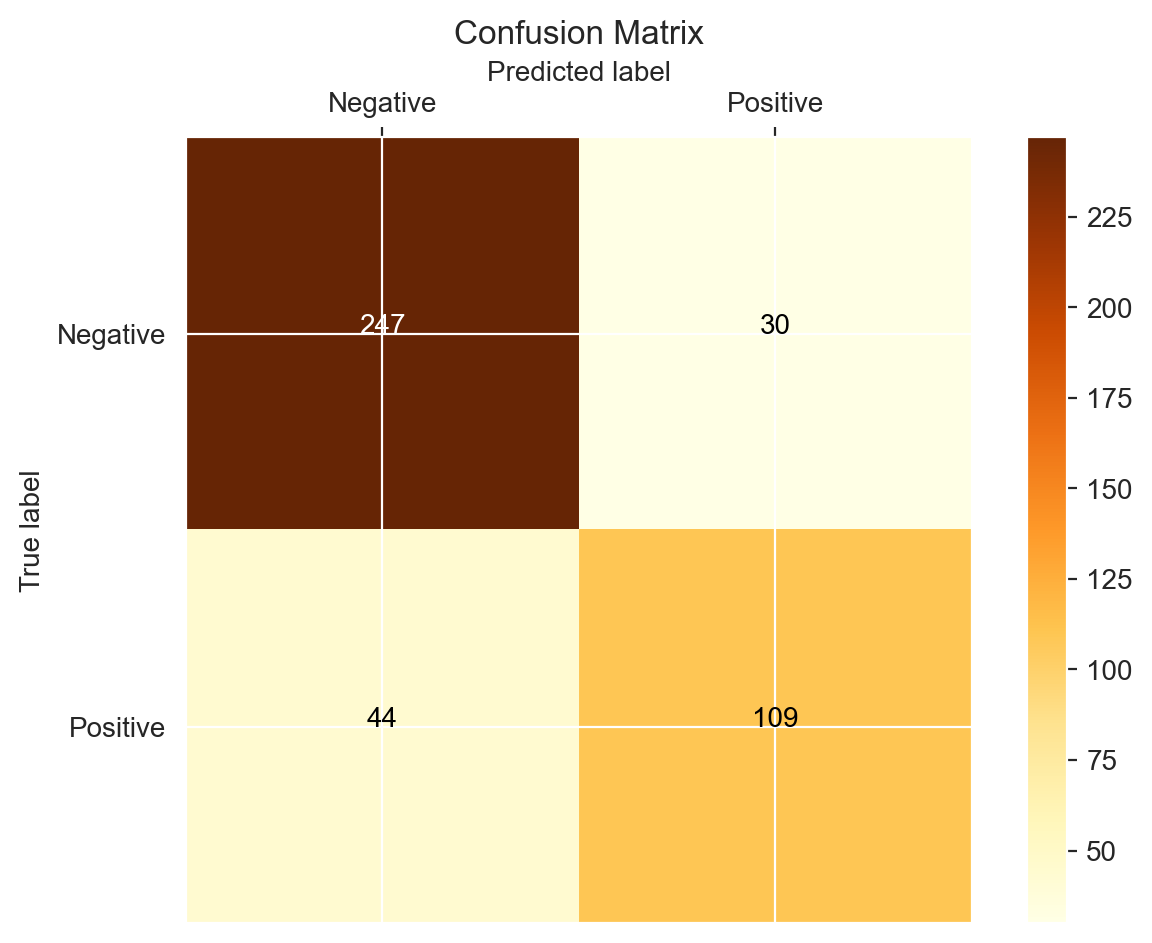

In [14]:
# Testing best logistic regression model
best_logreg_model = grid_search_log.best_estimator_

test_predictions_logreg = best_logreg_model.predict(test)

test_accuracy_logreg = accuracy_score(y_test, test_predictions_logreg)

print(f"Test Accuracy (Logistic Regression): {test_accuracy_logreg*100:.3f}")

# Classification Report
print(metrics.classification_report(y_test, test_predictions_logreg))

# Predict probabilities
probabilities_logreg = best_logreg_model.predict_proba(test)

# Probabilities for positive class
auc = roc_auc_score(y_test, probabilities_logreg[:, 1])

print(f"AUC-ROC score for Logistic Regression is {auc}")

# Confusion Matrix
draw_confusion_matrix(y_test, test_predictions_logreg, ['Negative', 'Positive'])

In [15]:
# Building decision tree model

# Optimizing
params = {
    'max_depth': [5, 10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
}


tree = DecisionTreeClassifier()

grid_search_tree = HalvingGridSearchCV(estimator=tree, param_grid=params, cv=10, n_jobs=-1)

# Fitting GridSearch
grid_result_tree = grid_search_tree.fit(train, y_train)

# Best parameters
print("Best parameters found: ", grid_result_tree.best_params_)
print("Highest accuracy: ", grid_result_tree.best_score_)



/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10500 fits failed out of a total of 42000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5614 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/aidancone/anaconda3/envs/Alzheimers_I

Best parameters found:  {'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_samples_split': 5}
Highest accuracy:  0.9276825891311873


/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.9193406 0.9193406 0.9193406]
  warnings.warn(
/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.94789312 0.94789312 0.94789312]
  warnings.warn(


Test Accuracy (Decision Tree): 93.721
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       277
           1       0.95      0.87      0.91       153

    accuracy                           0.94       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.94      0.94       430

AUC-ROC score for tree classifier is 0.9354073759467686


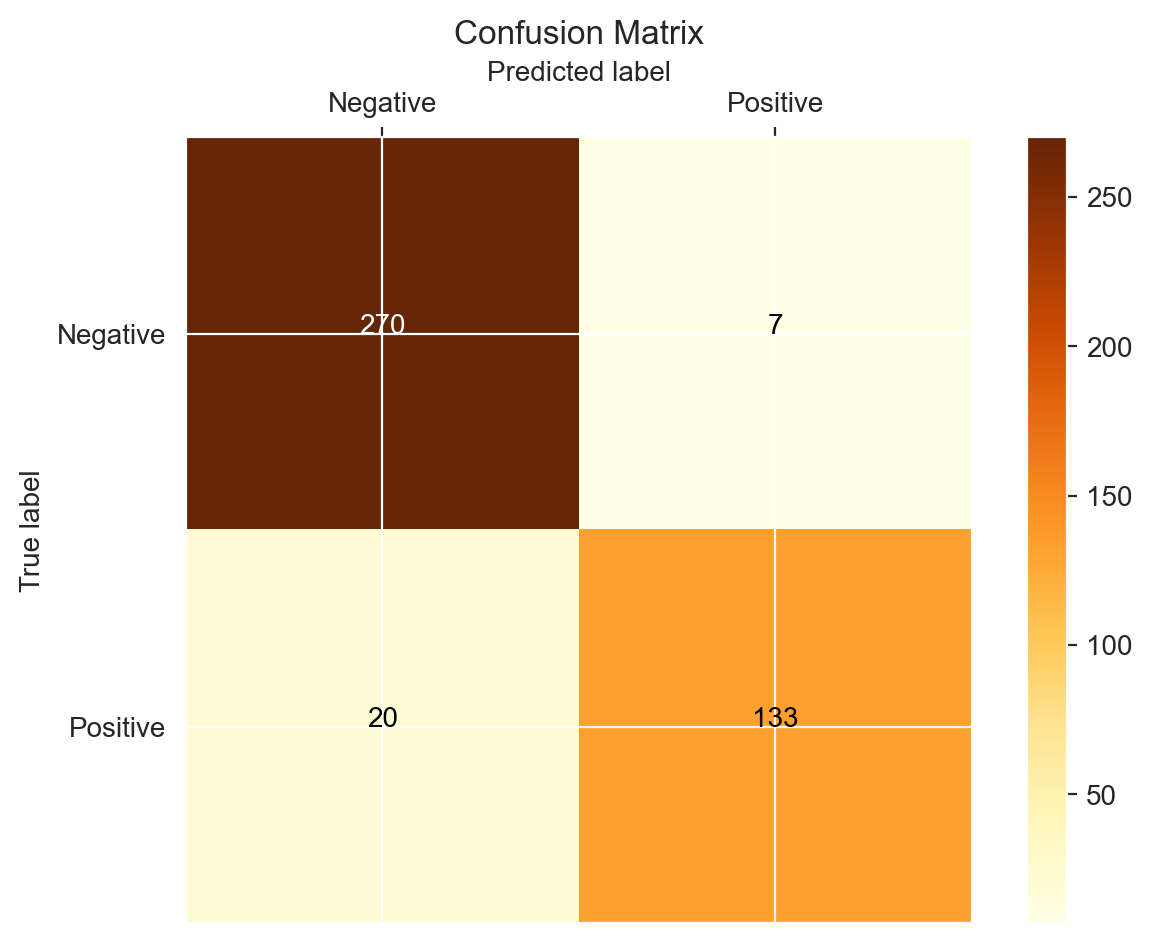

In [16]:
# Testing best decision tree model
best_tree_model = grid_search_tree.best_estimator_

test_predictions_tree = best_tree_model.predict(test)

test_accuracy_tree = accuracy_score(y_test, test_predictions_tree)

print(f"Test Accuracy (Decision Tree): {test_accuracy_tree*100:.3f}")

# Classification Report
print(metrics.classification_report(y_test, test_predictions_tree))

# Predict probabilities
probabilities_tree = best_tree_model.predict_proba(test)

# Probabilities for positive class
auc = roc_auc_score(y_test, probabilities_tree[:, 1])

print(f"AUC-ROC score for tree classifier is {auc}")

# Confusion Matrix
draw_confusion_matrix(y_test, test_predictions_tree, ['Negative', 'Positive'])

In [17]:
# Random forest classifier

# Define the parameters
params_refined = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, 35, 40, 45, 50, 55, 60, None],
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [400, 450, 500, 550],
    'oob_score': [True, False]
}




rf = RandomForestClassifier()

grid_search_rf = HalvingGridSearchCV(estimator=rf,param_grid=params, cv=10, n_jobs=-1)

# Run the grid search
grid_search_rf.fit(train, y_train)

# Print out the best parameters
print("Best parameters found: ", grid_search_rf.best_params_)
print("Highest accuracy found: ", grid_search_rf.best_score_)


/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10500 fits failed out of a total of 42000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5153 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aidancone/anaconda3/envs/Alzheimers_Investigation/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/aidancone/anaconda3/envs/Alzheimers_I

Best parameters found:  {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}
Highest accuracy found:  0.9425147109726547


Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 45, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500}
Highest accuracy found:  0.938785241907414

Test Accuracy (Random Forest): 95.116
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       277
           1       0.95      0.91      0.93       153

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430

AUC-ROC score for Random Forest is 0.9593331917604587


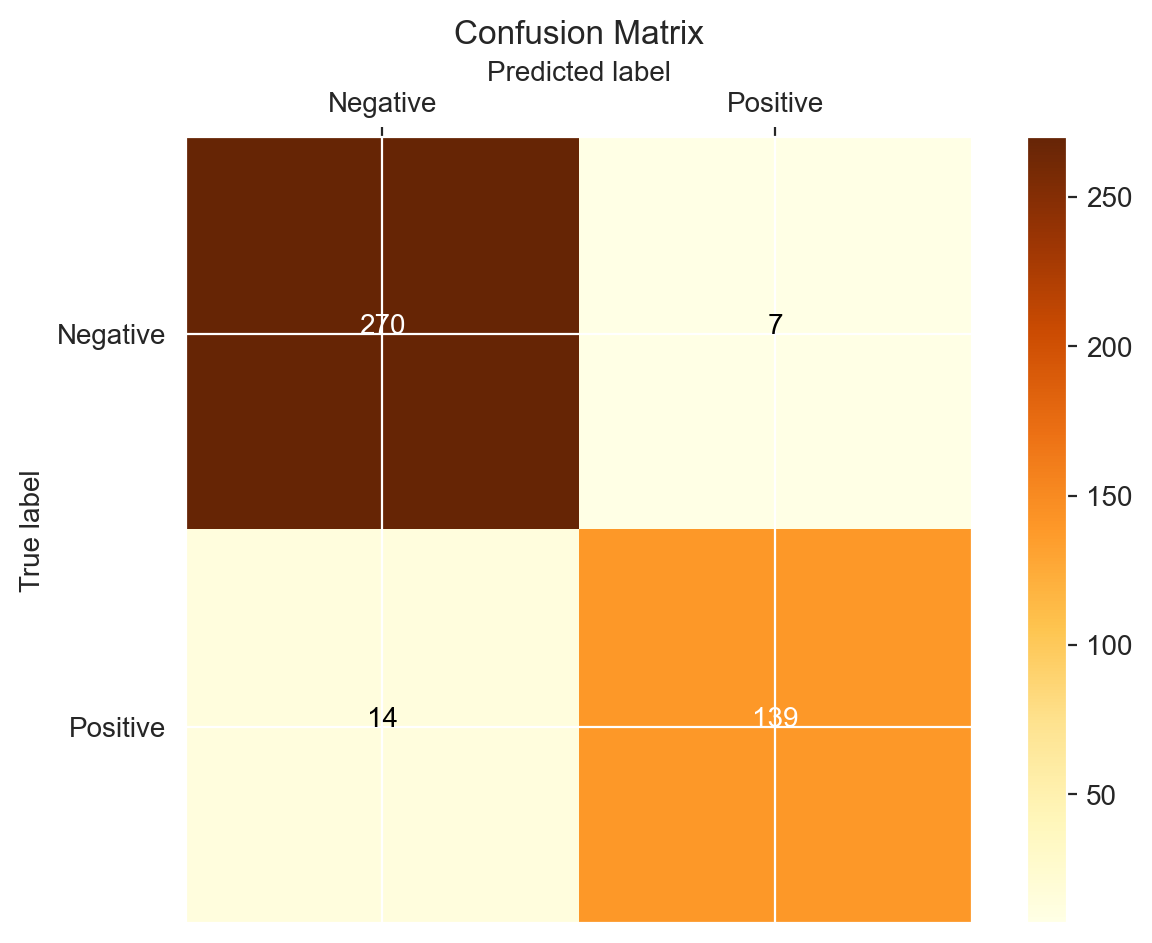

In [18]:
# Testing the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Predict on the testing data
test_predictions_rf = best_rf_model.predict(test)

# Get the accuracy of the model
test_accuracy_rf = accuracy_score(y_test, test_predictions_rf)

print(f"Test Accuracy (Random Forest): {test_accuracy_rf * 100:.3f}")

# Check the classification report
print(metrics.classification_report(y_test, test_predictions_rf))

# Predict probabilities
probabilities_rf = best_rf_model.predict_proba(test)

# Probabilities for positive class
auc = roc_auc_score(y_test, probabilities_rf[:, 1])

print(f"AUC-ROC score for Random Forest is {auc}")

# Confusion Matrix
draw_confusion_matrix(y_test, test_predictions_rf, ['Negative', 'Positive'])

In [22]:
# Building MLP classifier

# Define the parameters
params = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

mlp = MLPClassifier(max_iter=1000)

grid_search_mlp = HalvingGridSearchCV(estimator=mlp, param_grid=params, cv=10, n_jobs=-1)

# Run the grid search
grid_search_mlp.fit(train, y_train)

# Print out the best parameters
print("Best parameters found: ", grid_search_mlp.best_params_)
print("Highest accuracy found: ", grid_search_mlp.best_score_)


Best parameters found:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Highest accuracy found:  0.8387051862164985


Test Accuracy (MLP Classifier): 83.256
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       277
           1       0.80      0.71      0.75       153

    accuracy                           0.83       430
   macro avg       0.82      0.81      0.81       430
weighted avg       0.83      0.83      0.83       430

AUC-ROC score for MLP Classifier is 0.8941978716877846


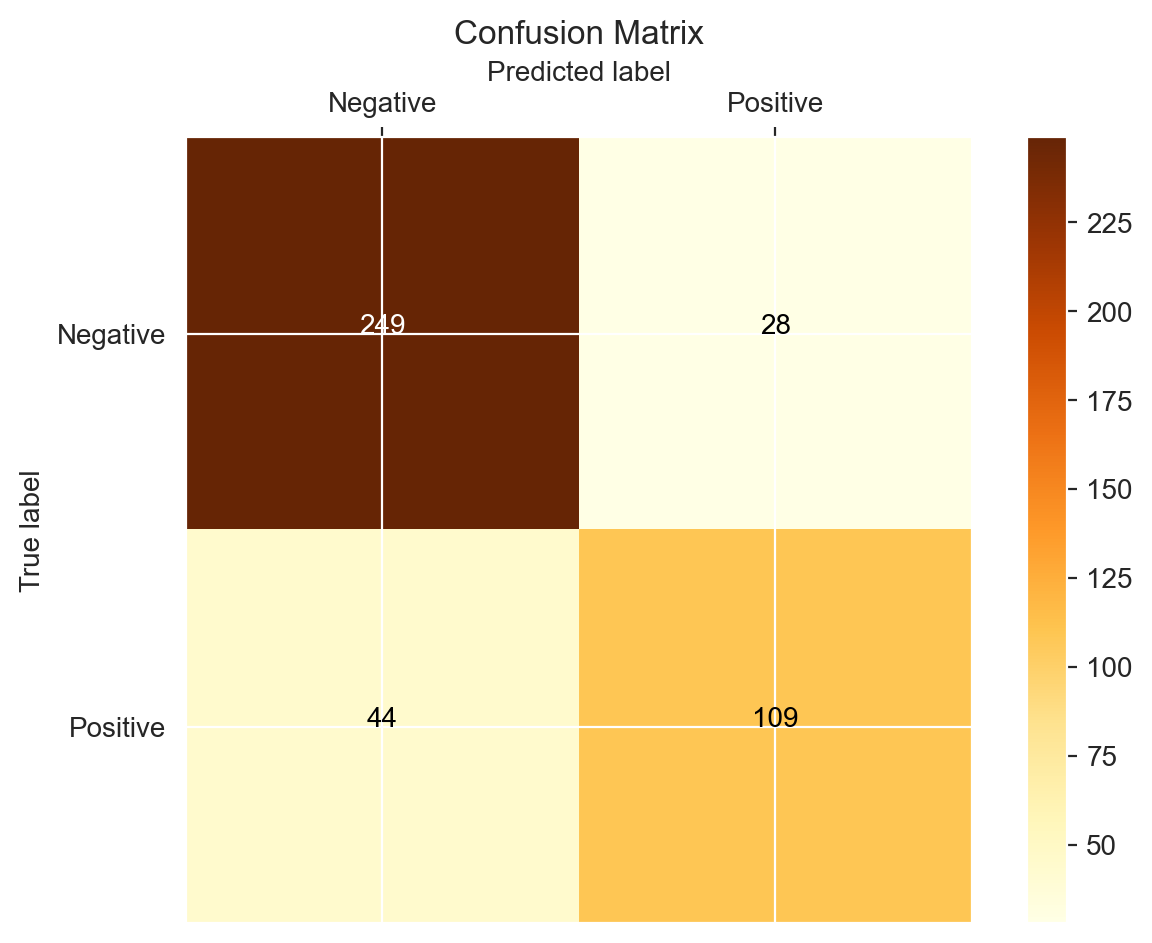

In [23]:
# Testing the best MLP model
best_mlp_model = grid_search_mlp.best_estimator_

# Predict on the testing data
test_predictions_mlp = best_mlp_model.predict(test)

# Get the accuracy of the model
test_accuracy_mlp = accuracy_score(y_test, test_predictions_mlp)

print(f"Test Accuracy (MLP Classifier): {test_accuracy_mlp * 100:.3f}")

# Check the classification report
print(metrics.classification_report(y_test, test_predictions_mlp))

# Predict probabilities
probabilities_mlp = best_mlp_model.predict_proba(test)

# Probabilities for positive class
auc = roc_auc_score(y_test, probabilities_mlp[:, 1])

print(f"AUC-ROC score for MLP Classifier is {auc}")

# Draw Confusion Matrix
draw_confusion_matrix(y_test, test_predictions_mlp, ['Negative', 'Positive'])


In [16]:
# making bagging classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# make baseline model
base_estimator_1 = DecisionTreeClassifier(random_state=SEED)

# parameters 
params = {
    'n_estimators': [100, 200, 300],
    'max_samples': [0.5, 0.6, 0.7, 0.8],
    'max_features': [0.5, 0.6, 0.7, 0.8],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'estimator': [base_estimator_1],
    'warm_start': [True, False]
}


bag_clf = BaggingClassifier(random_state=SEED)

hgs_bag = HalvingGridSearchCV(bag_clf, params, scoring='accuracy', cv=10, n_jobs=-1)

# train model
hgs_bag.fit(train, y_train)

# print best parameters and score
print("Best parameters found: ", hgs_bag.best_params_)
print("Highest accuracy found: ", hgs_bag.best_score_)


Best parameters found:  {'bootstrap': True, 'bootstrap_features': False, 'estimator': DecisionTreeClassifier(random_state=42), 'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 300, 'warm_start': True}
Highest accuracy found:  0.9379110418830046


Test Accuracy: 94.651
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       277
           1       0.96      0.88      0.92       153

    accuracy                           0.95       430
   macro avg       0.95      0.93      0.94       430
weighted avg       0.95      0.95      0.95       430

AUC-ROC score is 0.9555933083221254


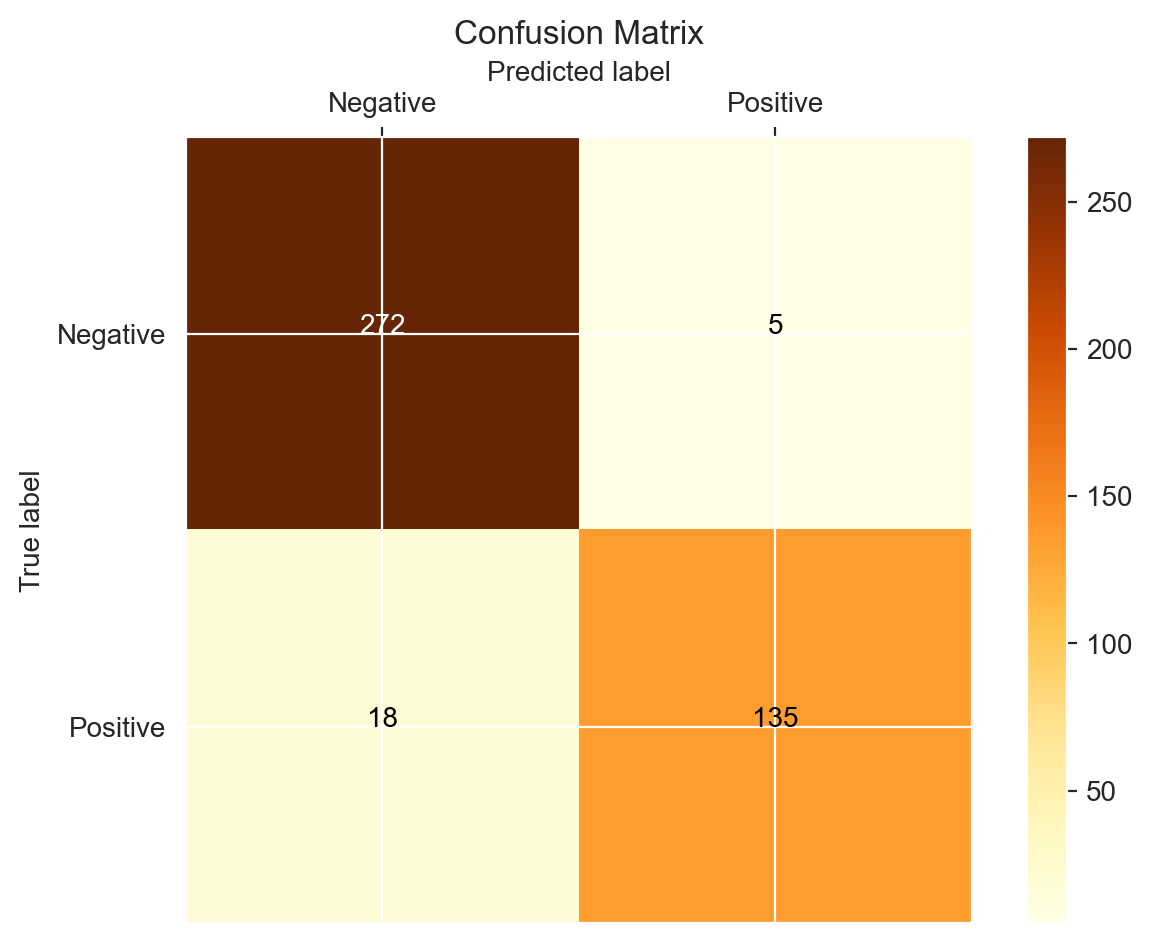

In [17]:
# Grab the best model from the Halving Grid Search
best_bagging_model = hgs_bag.best_estimator_

# Use the model to make predictions on the test set
test_predictions = best_bagging_model.predict(test)

# Get the accuracy of the model
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy * 100:.3f}")

# Check the classification report
print(metrics.classification_report(y_test, test_predictions))

# Probabilities for positive class
probabilities = best_bagging_model.predict_proba(test)
auc = roc_auc_score(y_test, probabilities[:, 1])

print(f"AUC-ROC score is {auc}")

# Draw the confusion matrix
draw_confusion_matrix(y_test, test_predictions, ['Negative', 'Positive'])


In [ ]:
# parameters 
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [5, 10, 15, -1],  # max depth for base learners, -1 means no restriction
    'min_child_samples': [20, 30, 40],  # minimum number of data needed in a child(leaf)
    'subsample': [0.8, 0.9, 1]  # the fraction of samples to be used for fitting the individual base learners
}


lgbm = LGBMClassifier(random_state=SEED)

hgs_lgbm = HalvingGridSearchCV(lgbm, params, scoring='accuracy', cv=10, n_jobs=-1, verbose=0)

# train model
hgs_lgbm.fit(train, y_train)

# print best parameters and score
print("Best parameters found: ", hgs_lgbm.best_params_)
print("Highest accuracy found: ", hgs_lgbm.best_score_)


In [ ]:
# Grab the best model from the Halving Grid Search
best_lgbm_model = hgs_lgbm.best_estimator_

# Use the model to make predictions on the test set
test_predictions = best_lgbm_model.predict(test)

# Get the accuracy of the model
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy * 100:.3f}")

# Check the classification report
print(metrics.classification_report(y_test, test_predictions))

# Probabilities for positive class
probabilities = best_lgbm_model.predict_proba(test)
auc = roc_auc_score(y_test, probabilities[:, 1])

print(f"AUC-ROC score is {auc}")